In [139]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import shutil

# Kaggle cat dataset

In [140]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    labels = load_labels(path)[1:]

    h,w = img.shape[:2]
    
    return img, labels , w , h
    
def load_labels(path):
    path = path + ".cat"
    
    with open(path,'r') as f:
        coordinates = f.readline()
        coordinates = str(coordinates).split(' ')[:-1]
    
    return list(map(int,coordinates))

339 159
250 25
407 14


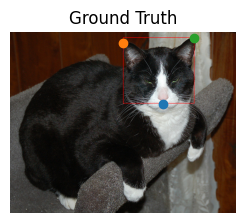

In [141]:
img,l,w,h = load_image('archive/CAT_05/00001100_003.jpg')
print(l[4],l[5])
print(l[8],l[9])
print(l[14],l[15])
xmin = min(l[4],l[8],l[14])
xmax = max(l[4],l[8],l[14])
ymin = min(l[5],l[9],l[15])
ymax = max(l[5],l[9],l[15])
imgrec = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255, 0, 0))
figure = plt.subplot(1,2,1)
figure.set_title('Ground Truth')
plt.axis('off')
plt.imshow(img)
plt.scatter(l[4],l[5])
plt.scatter(l[8],l[9])
plt.scatter(l[14],l[15])
# mouth: 4,5
# left ear: 8,9
# right ear: 14,15


In [142]:
img,l,w,h = load_image('archive/CAT_05/00001100_003.jpg')
print(l[4],l[5])
print(l[8],l[9])
print(l[14],l[15])
xmin = min(l[4],l[8],l[14])
xmax = max(l[4],l[8],l[14])
ymin = min(l[5],l[9],l[15])
ymax = max(l[5],l[9],l[15])

339 159
250 25
407 14


In [143]:
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [144]:
for dir in glob("archive/*"):
    for file in glob(f"{dir}/*.cat"):
        with open(file,'r') as f:
            coordinates = f.readlines()
            if len(coordinates)>1:
                print(file)
                print(len(coordinates))

In [145]:
os.makedirs("cats_data/images")
for dir in tqdm(glob("archive/*")):
    for file in glob(f"{dir}/*.jpg"):
        img,l,w,h = load_image(file)
        filename = file.split("/")[-1].split(".")[0]
        xmin = min(l[4],l[8],l[14])
        xmax = max(l[4],l[8],l[14])
        ymin = min(l[5],l[9],l[15])
        ymax = max(l[5],l[9],l[15])
        b = (xmin, xmax, ymin, ymax)
        bb = convert((w,h), b)
        f = open(os.path.join("cats_data",f"{filename}.txt"), "w")
        f.write(f"0 {round(bb[0],6)} {round(bb[1],6)} {round(bb[2],6)} {round(bb[3],6)}\n")
        f.close()
        shutil.copy(file, "cats_data/images")

100%|██████████| 8/8 [01:22<00:00, 10.35s/it]


# oxford-iiit-pet

In [146]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import shutil

In [147]:
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [148]:
with open("oxford-iiit-pet/annotations/trainval.txt",'r') as f:
    d1 = f.readlines()
with open("oxford-iiit-pet/annotations/test.txt",'r') as f:
    d2 = f.readlines()
data = d1+d2

In [149]:
for d in tqdm(data):
    if int(d.split(" ")[2]) == 1:
        filename = d.split(" ")[0]
        if not os.path.exists(os.path.join("oxford-iiit-pet","annotations","xmls", f"{filename}.xml")):
            continue
        with open(os.path.join("oxford-iiit-pet","annotations","xmls", f"{filename}.xml"),'r') as f:
            info = f.read()
        Bs_data = BeautifulSoup(info, "xml")
        xmin_lst = Bs_data.find_all('xmin')
        xmax_lst = Bs_data.find_all('xmax')
        ymin_lst = Bs_data.find_all('ymin')
        ymax_lst = Bs_data.find_all('ymax')
        w = int(Bs_data.find_all('width')[0].text)
        h = int(Bs_data.find_all('height')[0].text)
        f = open(os.path.join("cats_data",f"{filename}.txt"), "w")
        for i in range(len(xmin_lst)):
            xmin = int(xmin_lst[i].text)
            xmax = int(xmax_lst[i].text)
            ymin = int(ymin_lst[i].text)
            ymax = int(ymax_lst[i].text)
            b = (xmin, xmax, ymin, ymax)
            bb = convert((w,h), b)
            f.write(f"0 {round(bb[0],6)} {round(bb[1],6)} {round(bb[2],6)} {round(bb[3],6)}\n")
        f.close()
        shutil.copy(os.path.join("oxford-iiit-pet","images", f"{filename}.jpg"), "cats_data/images")


100%|██████████| 7349/7349 [00:02<00:00, 2678.18it/s]


# Format Yolo folders

In [150]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [152]:
if not os.path.exists("cats_data/train.txt") and not os.path.exists("cats_data/val.txt"):
    data = []
    os.makedirs("cats_data/images/train")
    os.makedirs("cats_data/images/val")
    os.makedirs("cats_data/labels/train")
    os.makedirs("cats_data/labels/val")
    for file in glob("cats_data/*.txt"):
        filename = file.split("/")[-1].split(".")[0]
        data.append(filename)
    train, val = train_test_split(data, test_size=0.2, random_state=42)
    f = open("cats_data/train.txt", "w")
    for d in train:
        f.write(f"./images/train/{d}.jpg\n")
        shutil.move(os.path.join("cats_data","images", f"{d}.jpg"), os.path.join("cats_data","images","train"))
        shutil.move(os.path.join("cats_data", f"{d}.txt"), os.path.join("cats_data","labels","train"))
    f.close()
    f = open("cats_data/val.txt", "w")
    for d in val:
        f.write(f"./images/val/{d}.jpg\n")
        shutil.move(os.path.join("cats_data","images", f"{d}.jpg"), os.path.join("cats_data","images","val"))
        shutil.move(os.path.join("cats_data", f"{d}.txt"), os.path.join("cats_data","labels","val"))
    f.close()